<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_14_%EC%88%98(MI_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Word Embedding & CNN을 이용한 감성분석
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pickle

# 학습, 시험 데이터를 읽어온다.
with open('/content/drive/MyDrive/머신러닝/popcorn.pkl', 'rb') as f:
    x_train, y_train, x_test, y_test, word2idx = pickle.load(f)

y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

# 각 리뷰의 길이를 측정하고, 평균 길이를 구한다.
x_len = [len(x) for x in x_test]

print('평균 =', np.mean(x_len))
print('최소 =', np.min(x_len))
print('최대 =', np.max(x_len))
print('중앙값 =', np.median(x_len))


평균 = 79.0452
최소 = 5
최대 = 625
중앙값 = 60.0


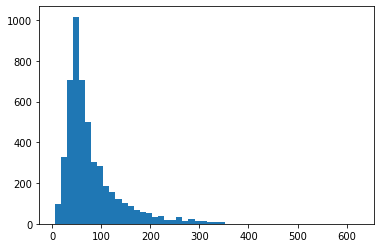

In [ ]:
# 길이 분포를 확인한다.
plt.hist(x_len, bins=50)
plt.show()


In [ ]:
# 각 리뷰의 길이를 max_seq_len로 맞춘다. 길면 자르고, 짧으면 padding을 추가한다.
MAX_SEQ_LEN = 120
x_train = pad_sequences(x_train, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# CNN 모델을 빌드한다.
VOCAB_SIZE = len(word2idx)
EMB_SIZE = 32
NUM_FILTER = 32

# Convolution & Pooling
def conv1d_maxpool(x, k):
    conv = Conv1D(filters=NUM_FILTER, kernel_size=k, activation='relu',
               kernel_regularizer=regularizers.l2(0.005))(x)
    return GlobalMaxPool1D()(conv)

x_input = Input(batch_shape=(None, x_train.shape[1]))
emb = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
emb = Dropout(rate=0.5)(emb)

pool1 = conv1d_maxpool(emb, k=3)  # 3-gram
pool2 = conv1d_maxpool(emb, k=4)  # 4-gram
pool3 = conv1d_maxpool(emb, k=5)  # 5-gram
concat = Concatenate()([pool1, pool2, pool3])
y_output = Dense(1, activation='sigmoid')(concat)

model = Model(x_input, y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 120, 32)      192064      input_18[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 120, 32)      0           embedding_17[0][0]               
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 118, 32)      3104        dropout_19[0][0]                 
____________________________________________________________________________________________

In [ ]:
# 학습
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 512, epochs = 30)

Epoch 1/30
40/40 [==============================] - 11s 246ms/step - loss: 1.0900 - val_loss: 1.0094
Epoch 2/30
40/40 [==============================] - 10s 244ms/step - loss: 0.9530 - val_loss: 0.8965
Epoch 3/30
40/40 [==============================] - 10s 243ms/step - loss: 0.8566 - val_loss: 0.8141
Epoch 4/30
40/40 [==============================] - 10s 244ms/step - loss: 0.7799 - val_loss: 0.7388
Epoch 5/30
40/40 [==============================] - 10s 245ms/step - loss: 0.6995 - val_loss: 0.6561
Epoch 6/30
40/40 [==============================] - 10s 244ms/step - loss: 0.6208 - val_loss: 0.5888
Epoch 7/30
40/40 [==============================] - 10s 242ms/step - loss: 0.5624 - val_loss: 0.5440
Epoch 8/30
40/40 [==============================] - 10s 245ms/step - loss: 0.5197 - val_loss: 0.5122
Epoch 9/30
40/40 [==============================] - 10s 244ms/step - loss: 0.4907 - val_loss: 0.4882
Epoch 10/30
40/40 [==============================] - 10s 245ms/step - loss: 0.4669 - val_lo

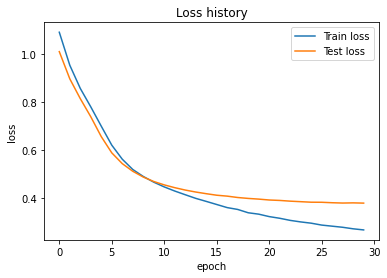


Accuracy = 86.14 %
ROC AUC score = 0.93


In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))
print("ROC AUC score = %.2f" % (roc_auc_score(y_test, pred)))